# Testing a skewed Gaussian

We test a skewed Gaussian model to see whether this is a better option than the comet model that assumes shapes are forward-moving only.

## Importing libraries

In [1]:
import os

os.chdir("../")
import lightkurve as lk
from matplotlib import pyplot as plt
import numpy as np
from astropy.table import Table
from scripts.analysis_tools_cython import *
import scipy.integrate as integrate
import numpy as np
from scipy.signal import savgol_filter
from scipy.stats import chisquare

In [2]:
plt.rcParams["figure.figsize"] = (10, 6)

## Functions

In [3]:
def skewed_gaussian_curve_fit2(x, y, y_err):
    # Initial parameters guess
    ## i = index of min time
    ## x = time
    ## y = flux
    
    i = np.argmin(y)
    width = x[-1]-x[0]
    ### params initialisation for skewness, time, mean and sigma
    params_init = [0.1,x[i],0.1,0.1] # i find these good to initialise with    
    params_bounds = [[-np.inf,x[0],0,0], [np.inf,x[-1],width/3,width/3]] # width/3 I think is the sensible choice.
    params,cov = curve_fit(skewed_gaussian,x,y,bounds=params_bounds,p0=params_init,sigma=y_err)
    
    return params, cov 


def skewed_gaussian(x, a, mean, sigma, m):
    """
    m: amplitude
    x: time
    a: skewness
    mean: time
    sigma: sigma/standard deviation

    """
    return -m * skewnorm.pdf(x, a, loc=mean, scale=sigma)


def lookup_tic(tic):
    return lookup[lookup.TIC_ID == tic]


def search_method(data):
    try:
        data = data["time", "corrected flux", "quality", "flux error"]
    except:
        data = data["TIME", "PDCSAP_FLUX", "QUALITY", "PDCSAP_FLUX_ERR"]

    try:
        data["corrected flux"] = normalise_error(
            data["corrected flux"], data["flux error"]
        )
    except:
        data["PDCSAP_FLUX_ERR"] = normalise_error(
            data["PDCSAP_FLUX"], data["PDCSAP_FLUX_ERR"]
        )

    flat_flux, trend_flux = smoothing(data, method="median")
    a = Table()
    a["time"] = data[data.colnames[0]]
    a["flux"] = flat_flux - np.ones(len(flat_flux))
    a["quality"] = data[data.colnames[2]]
    a["flux_error"] = data[data.colnames[3]]
    # table[table.colnames[1]] = flat_flux - np.ones(len(flat_flux)) # resets normalisation to zero instead of one.
    t, flux, quality, real, flux_error = clean_data(a)
    flux *= real
    timestep = calculate_timestep(data)
    factor = (1 / 48) / timestep

    T1 = test_statistic_array(flux, 60 * factor)

    m, n = np.unravel_index(
        T1.argmin(), T1.shape
    )  # T.argmin(): location of  T.shape: 2D array with x,y points in that dimension
    minT = T1[m, n]
    # Ts = nonzero(T1[m,n]).std()
    minT_time = t[n]
    minT_duration = m * timestep
    Tm_start = n - math.floor((m - 1) / 2)
    Tm_end = Tm_start + m
    Tm_depth = flux[Tm_start:Tm_end].mean()
    Ts = nonzero(T1[m]).std()  # only the box width selected. Not RMS of all T-statistic

    asym, width1, width2, depth, info, skewness, skewness_error = calc_shape2(
        m, n, t, flux, quality, flux_error
    )
    return info[0], info[1], info[3]


def plot(data):
    time, flux, error = search_method(data)
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    try:
        ax[0].plot(data["time"], data["corrected flux"])
    except:
        ax[0].plot(data["TIME"], data["PDCSAP_FLUX"])
    ax[1].plot(time, flux)
    ax[1].plot(time, fit, label="gaussian")
    ax[1].plot(time, fit2, color="black", label="skewed gaussian")
    ax[1].legend()
    # ax[1].errorbar(time,flux, yerr=error, fmt='', color='b')
    plt.show()


def calc_reduced_chi_square(fit, x, y, yerr, N, n_free):
    """
    fit (array) values for the fit
    x,y,yerr (arrays) data
    N total number of points
    n_free number of parameters we are fitting
    """
    return 1.0 / (N - n_free) * sum(((fit - y) / yerr) ** 2)


def normalise_error(flux, flux_error):
    return flux_error / np.nanmean(flux)


def calc_shape2(
    m, n, time, flux, quality, flux_error, n_m_bg_start=3, n_m_bg_scale_factor=1
):
    # exploratory cutout function. not to be confused with calc_shape from analysis_tools_cython
    """Fit both symmetric and comet-like transit profiles and compare fit.
    Returns:
    (1) Asymmetry: ratio of (errors squared)
    Possible errors and return values:
    -1 : Divide by zero as comet profile is exact fit
    -2 : Too close to end of light curve to fit profile
    -3 : Unable to fit model (e.g. timeout)
    -4 : Too much empty space in overall light curve or near dip
    (2,3) Widths of comet curve fit segments.
    info: t, x, q, fit1 and fit2 are the transit shape elements

    """
    ## how many transit widths to take the general linear trend from. start is 1/4 length of cutout from beginning, end is 1 from end.
    # first_index = n - (n_m_bg_start*n)
    # last_index = n - (n_m_bg_end*m)

    ## the transit widths of the cutout from the T-statistic minimum value.
    ## this project requires the cutout to have more transit widths after the midtransit, to cover more of the tail.
    ## default is set to 1 transit width before and 2 transit widths after

    n_m_bg_end = n_m_bg_scale_factor * n_m_bg_start

    cutout_before = n - (m * n_m_bg_start)
    cutout_after = n + (m * n_m_bg_end)

    if cutout_before >= 0 and cutout_after < len(time):
        t = time[cutout_before:cutout_after]
        if (t[-1] - t[0]) / np.median(np.diff(t)) / len(t) > 1.5:
            return -4, -4, -4, -4, -4, -4, -4
        t0 = time[n]
        diffs = np.diff(t)

        x = flux[cutout_before:cutout_after]
        q = quality[cutout_before:cutout_after]
        fe = flux_error[cutout_before:cutout_after]

        bg_before = np.mean(x[: int(m / 4)])
        bg_time_before = np.mean(t[: int(m / 4)])
        bg_after = np.mean(x[-int(round(m / 4)) :])
        bg_time_after = np.mean(t[-int(round(m / 4)) :])

        grad = (bg_after - bg_before) / (bg_time_after - bg_time_before)
        background_level = bg_before + grad * (t - bg_time_before)
        x = x - background_level

        try:
            params1, pcov1 = single_gaussian_curve_fit(t, -x)
            params2, pcov2 = comet_curve_fit(t, -x)
            params3, pcov3 = skewed_gaussian_curve_fit2(t, x, fe)
        except:
            return -3, -3, -3, -3, -3, -3, -3

        fit1 = -gauss(t, *params1)
        fit2 = -comet_curve(t, *params2)
        fit3 = skewed_gaussian(t, *params3)
        depth = (
            fit2.min()
        )  # depth of comet (based on minimum point; not entirely accurate, but majority of the time true)
        min_time = t[np.argmin(x)]  # time of midtransit/at minimum point
        scores = [
            score_fit(x, fit) for fit in [fit1, fit3]
        ]  # changed for the skewed gaussian fit
        if scores[1] > 0:
            skewness = params3[0]
            skewness_error = np.sqrt(np.diag(pcov3)[0])
            return (
                scores[0] / scores[1],
                params2[2],
                params2[3],
                depth,
                [t, x, q, fe, fit1, fit2, fit3, background_level],
                skewness,
                skewness_error,
            )
        else:

            return -1, -1, -1, -1, -1, -1, -1
    else:

        return -2, -2, -2, -2, -2, -2, -2

In [4]:
lookup = pd.read_csv("/storage/astro2/phrdhx/tesslcs/sector1lookup.csv")

## Example 1 - Beta Pic

In [5]:
data, lc_info = import_lightcurve(
    "betapic/hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_lc.fits"
)

In [6]:
time, flux, error = search_method(data)

In [7]:
params, cov = single_gaussian_curve_fit(time, -flux)
params1, cov1 = skewed_gaussian_curve_fit2(time, flux, error)

In [8]:
print(f"skewness is {round(params1[0],3)}+/-{np.sqrt(np.diag(cov1)[0])}")

skewness is 2.616+/-0.32523340926065913


In [9]:
fit = -gauss(time, *params)
fit2 = skewed_gaussian(time, *params1)

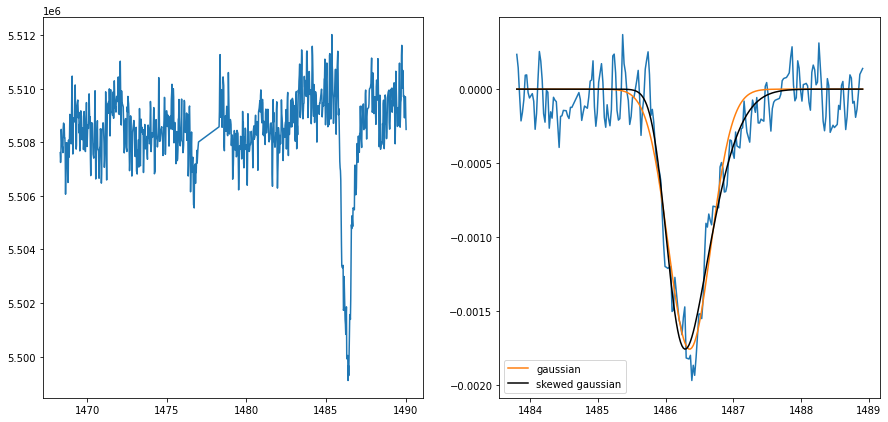

In [10]:
plot(data)

In [11]:
chisquare(flux)

Power_divergenceResult(statistic=-0.21396256987667883, pvalue=1.0)

## 1a. A "reverse Beta Pic"

In [12]:
data = data.to_pandas()

In [13]:
data.head()

,TIME,PDCSAP_FLUX,QUALITY,PDCSAP_FLUX_ERR
0,1468.304154,5507612.0,0,64.862846
1,1468.324987,5507246.5,0,64.860832
2,1468.345820,5507478.5,0,64.863037
3,1468.366654,5508482.0,0,64.867645
4,1468.408320,5507866.5,0,64.860580


In [14]:
data.PDCSAP_FLUX = data.PDCSAP_FLUX.values[::-1]

In [15]:
data = Table.from_pandas(data)

In [16]:
time, flux, error = search_method(data)

In [17]:
params, cov = single_gaussian_curve_fit(time, -flux)
params1, cov1 = skewed_gaussian_curve_fit2(time, flux, error)

In [18]:
print(f"skewness is {round(params1[0],3)}+/-{np.sqrt(np.diag(cov1)[0])}")

skewness is -3.151+/-0.3723817865399586


In [19]:
fit = -gauss(time, *params)
fit2 = skewed_gaussian(time, *params1)

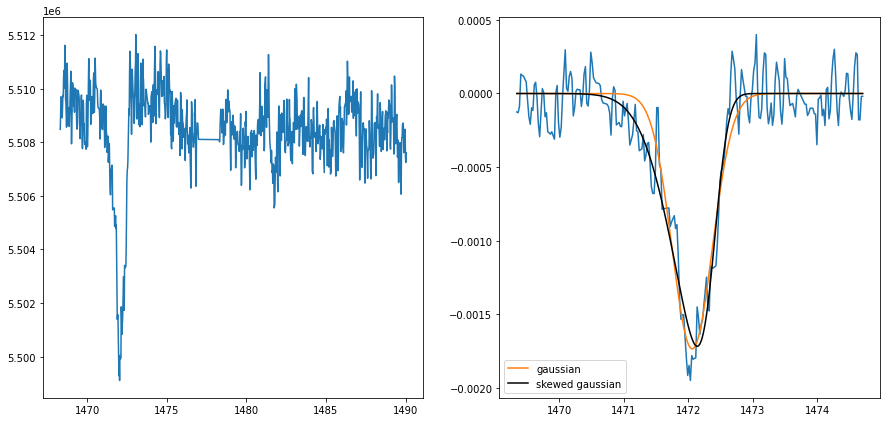

In [20]:
plot(data)

Appears to fit the data quite well.

### Goodness of fit of model

In [21]:
chisquare(flux)[0]

-0.23855244809197787

---

## Example 2 (CTOI)

In [22]:
data, lc_info = import_XRPlightcurve(
    "/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/2_min_cadence_targets/tesslc_50380257.pkl",
    sector=1,
)

In [23]:
time, flux, error = search_method(data)

In [24]:
params, cov = single_gaussian_curve_fit(time, -flux)
params1, cov1 = skewed_gaussian_curve_fit2(time, flux, error)

In [25]:
print(f"skewness is {round(params1[0],3)}+/-{np.sqrt(np.diag(cov1)[0])}")

skewness is -0.063+/-321.2335070746005


In [26]:
fit = -gauss(time, *params)
fit2 = skewed_gaussian(time, *params1)

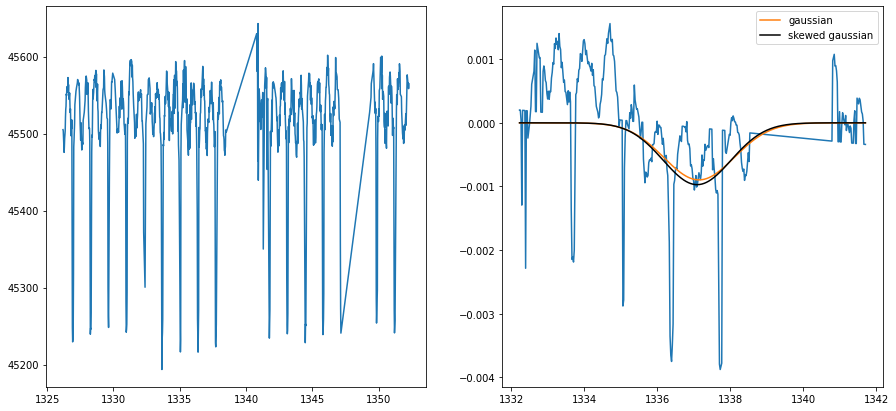

In [27]:
plot(data)

In [28]:
chisquare(flux)

Power_divergenceResult(statistic=-2.9688678875761556, pvalue=1.0)

---
## Example 3 (CTOI)

In [29]:
lookup_tic(55659311)

,Filename,RA,Dec,TIC_ID,Sector,Camera,CCD,Magnitude
12943,tesslcs_sector_1_104/2_min_cadence_targets/tes...,74.117326,-64.48753,55659311,1,4,1,9.7909


In [30]:
data, lc_info = import_XRPlightcurve(
    "/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/2_min_cadence_targets/tesslc_55659311.pkl",
    sector=1,
)

In [31]:
time, flux, error = search_method(data)

In [32]:
params, cov = single_gaussian_curve_fit(time, -flux)
params1, cov1 = skewed_gaussian_curve_fit2(time, flux, error)

In [33]:
print(f"skewness is {round(params1[0],3)}+/-{np.sqrt(np.diag(cov1)[0])}")

skewness is -0.001+/-181266.15097360022


In [34]:
fit = -gauss(time, *params)
fit2 = skewed_gaussian(time, *params1)

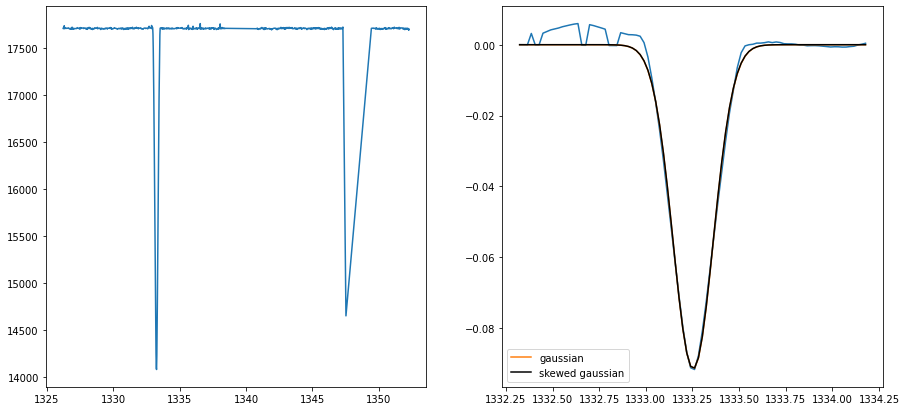

In [35]:
plot(data)

In [36]:
len(flux)

90

In [37]:
chisquare(flux)

Power_divergenceResult(statistic=-5.396892860570647, pvalue=1.0)

---
## Example 4 (EA2)

In [38]:
lookup_tic(60646247)

,Filename,RA,Dec,TIC_ID,Sector,Camera,CCD,Magnitude
53662,tesslcs_sector_1_104/tesslcs_tmag_11_12/tesslc...,334.360488,-33.134487,60646247,1,1,2,11.851


In [39]:
data, lc_info = import_XRPlightcurve(
    "/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/tesslcs_tmag_11_12/tesslc_60646247.pkl",
    sector=1,
)

In [40]:
time, flux, error = search_method(data)

In [41]:
params, cov = single_gaussian_curve_fit(time, -flux)
params1, cov1 = skewed_gaussian_curve_fit2(time, flux, error)

In [42]:
np.diag(cov1)

array([1.63570267e-01, 2.05460214e-05, 3.42913785e-05, 2.39139678e-07])

In [43]:
np.sqrt((cov1)[0, 0])

0.4044382121667801

In [44]:
print(f"skewness is {round(params1[0],3)}+/-{np.sqrt(np.diag(cov1)[0])}")

skewness is -1.96+/-0.4044382121667801


In [45]:
fit = -gauss(time, *params)
fit2 = skewed_gaussian(time, *params1)

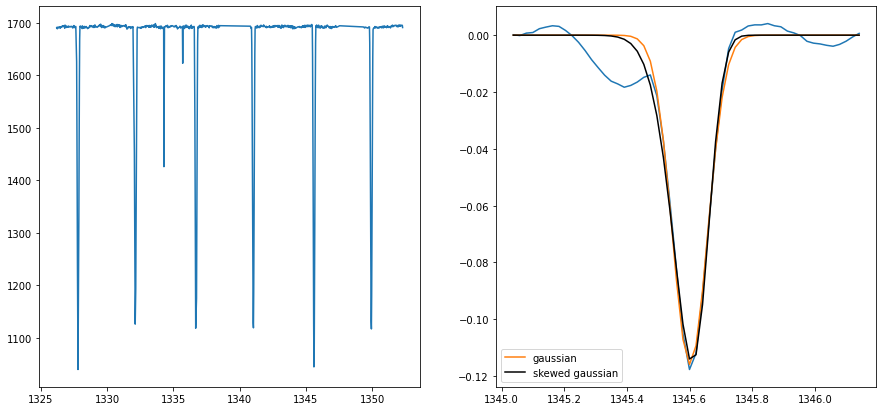

In [46]:
plot(data)

In [47]:
len(flux)

54

In [48]:
chisquare(flux)

Power_divergenceResult(statistic=-3.138270180367051, pvalue=1.0)

---
## Example 5 (WASP 100)

In [49]:
lookup_tic(38846515)

,Filename,RA,Dec,TIC_ID,Sector,Camera,CCD,Magnitude
12850,tesslcs_sector_1_104/2_min_cadence_targets/tes...,68.959709,-64.027037,38846515,1,4,1,10.3157


In [50]:
data, lc_info = import_XRPlightcurve(
    "/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/2_min_cadence_targets/tesslc_38846515.pkl",
    sector=1,
)

In [51]:
time, flux, error = search_method(data)

In [52]:
params, cov = single_gaussian_curve_fit(time, -flux)
params1, cov1 = skewed_gaussian_curve_fit2(time, flux, error)

In [53]:
print(f"skewness is {round(params1[0],3)}+/-{np.sqrt(np.diag(cov1)[0])}")

skewness is 9.53+/-91.43206643595708


In [54]:
params

array([1.64394370e-03, 1.33143108e+03, 7.40277230e-02])

In [55]:
fit = -gauss(time, *params)
fit2 = skewed_gaussian(time, *params1)

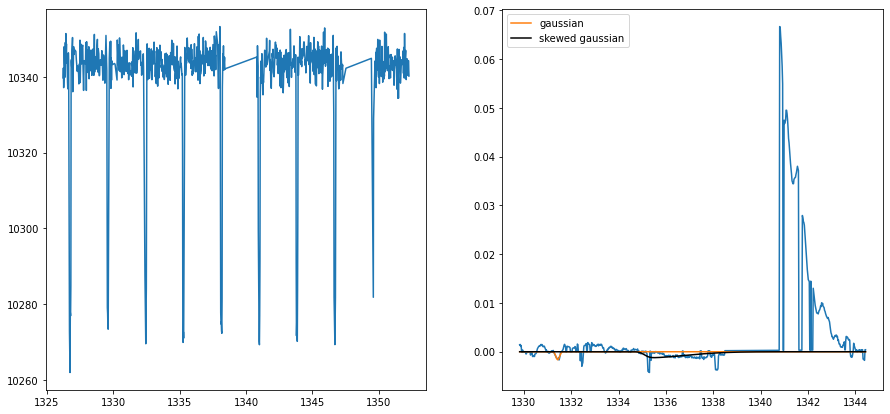

In [56]:
plot(data)

In [57]:
len(flux)

702

---
## Example 6

In [58]:
lookup_tic(61178236)

,Filename,RA,Dec,TIC_ID,Sector,Camera,CCD,Magnitude
43296,tesslcs_sector_1_104/tesslcs_tmag_10_11/tesslc...,334.803809,-31.688934,61178236,1,1,2,10.8952


In [59]:
data, lc_info = import_XRPlightcurve(
    "/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/tesslcs_tmag_10_11/tesslc_61178236.pkl",
    sector=1,
)

In [60]:
time, flux, error = search_method(data)

In [61]:
params, cov = single_gaussian_curve_fit(time, -flux)
params1, cov1 = skewed_gaussian_curve_fit2(time, flux, error)

In [62]:
print(f"skewness is {round(params1[0],3)}+/-{np.sqrt(np.diag(cov1)[0])}")

skewness is -0.612+/-0.47740181331558573


In [63]:
params

array([5.96566006e-02, 1.35117621e+03, 3.29850529e-02])

In [64]:
params1

array([-6.12069719e-01,  1.35119123e+03,  3.66582688e-02,  4.95783570e-03])

In [65]:
fit = -gauss(time, *params)
fit2 = skewed_gaussian(time, *params1)

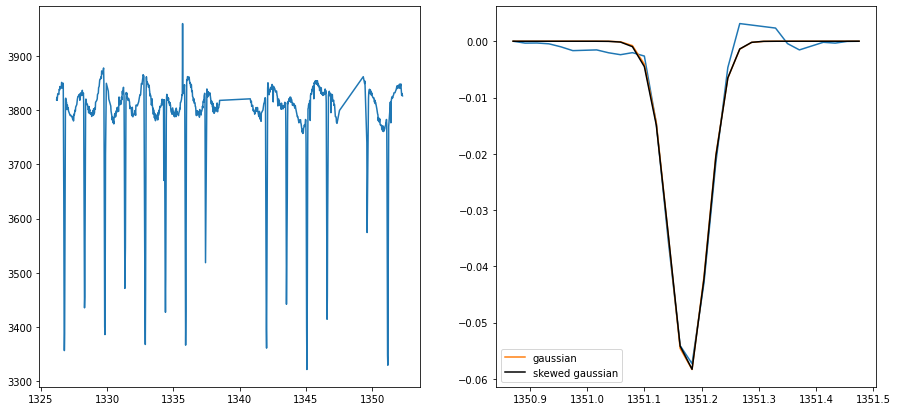

In [66]:
plot(data)

In [67]:
len(flux)

30

In [68]:
chisquare(flux)

Power_divergenceResult(statistic=-1.025490731500549, pvalue=1.0)

## Example 7

In [69]:
lookup_tic(441422220)

,Filename,RA,Dec,TIC_ID,Sector,Camera,CCD,Magnitude
6223,tesslcs_sector_1_104/2_min_cadence_targets/tes...,311.362145,-34.646424,441422220,1,1,4,9.0641


In [70]:
data, lc_info = import_XRPlightcurve(
    "/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/2_min_cadence_targets/tesslc_441422220.pkl",
    sector=1
)

In [71]:
time, flux, error = search_method(data)

In [72]:
params, cov = single_gaussian_curve_fit(time, -flux)
params1, cov1 = skewed_gaussian_curve_fit2(time, flux, error)

In [73]:
print(f"skewness is {round(params1[0],3)}+/-{np.sqrt(np.diag(cov1)[0])}")

skewness is 0.38+/-1.4439195160510068


In [74]:
params

array([1.50128820e-01, 1.35089299e+03, 4.05984544e-02])

In [75]:
params1

array([3.79541109e-01, 1.35088100e+03, 4.27243619e-02, 1.53459465e-02])

In [76]:
fit = -gauss(time, *params)
fit2 = skewed_gaussian(time, *params1)

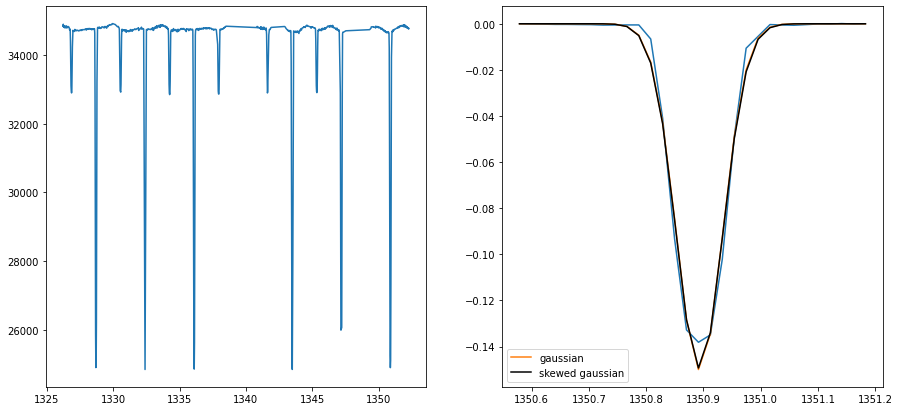

In [77]:
plot(data)

In [78]:
len(flux)

30

In [79]:
chisquare(flux)

Power_divergenceResult(statistic=-2.544658302544679, pvalue=1.0)